In [1]:
# user defined functions
import odor_statistics_lib as osm

# dataframes
import pandas as pd
import h5py

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import signal
from scipy import stats
import scipy.stats as st

#classification
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.ensemble import RandomForestClassifier

#plots
import string
import figurefirst
from figurefirst import FigureLayout,mpl_functions
import matplotlib.ticker as mtick
import pylab as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap
sns.set_style("whitegrid")
pd.options.mode.chained_assignment = None

In [2]:
dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/'

In [3]:
# acc = pd.read_hdf(dir+'Classifier/accuracy_Scores_desert_nwindy.h5')

## Classify

In [4]:
def create_class_column_forest(dataframe):
    dataframe.loc[dataframe.avg_dist_from_source < 5, 'type'] = 0
    dataframe.loc[(dataframe.avg_dist_from_source >= 5)  & (dataframe.avg_dist_from_source < 10), 'type'] = 1
    dataframe.loc[dataframe.avg_dist_from_source >= 10, 'type'] = 2
    return dataframe

def create_class_column(dataframe):
    dataframe.loc[dataframe.avg_dist_from_source < 5, 'type'] = 0
    dataframe.loc[(dataframe.avg_dist_from_source >= 5)  & (dataframe.avg_dist_from_source < 30), 'type'] = 1
    dataframe.loc[dataframe.avg_dist_from_source >= 30, 'type'] = 2
    return dataframe

def create_class_column_log(dataframe):
    dataframe.loc[dataframe.log_avg_dist_from_source_signed < 0.7, 'type'] = 0
    dataframe.loc[(dataframe.log_avg_dist_from_source_signed >= 0.7)  & 
                  (dataframe.log_avg_dist_from_source_signed < 1.5), 'type'] = 1
    dataframe.loc[dataframe.log_avg_dist_from_source_signed >= 1.5, 'type'] = 2
    return dataframe

def check_length(dataframe, Nrows, nrows,N):
    if (len(Nrows) !=N):
        rowsneeded  = N - len(Nrows) 
        Nrows = Nrows.append(dataframe[(nrows.index-rowsneeded).values[0]:(nrows.index).values[0]])
        Nrows = Nrows.sort_index()
        return Nrows
    else:
        return Nrows
    
def get_rows(dataframe, N):
    nrows = dataframe.sample(1)
    Nrows = dataframe[(nrows.index).values[0]:(nrows.index+N).values[0]]
    newrows = check_length(dataframe,Nrows, nrows, N)
    return newrows

# for each collection of data to use for the classifier, get statistics from N encounters
def get_N_consecutive_encounter_stats(dataframe, distance_class, N):
    df_q = dataframe.query('type == ' + str(distance_class))   
    df_q.reset_index(inplace=True, drop=True)     
    Nrows = get_rows(df_q,N)
    
    return np.ravel( Nrows[['mean_concentration','mean_ef','log_whiff','mean_ma']].values )


# for each collection of data to use for the classifier, get statistics from N encounters
def get_N_random_encounter_stats(dataframe, distance_class,N):
    df_q = dataframe.query('type == ' + str(distance_class))   
    df_q.reset_index(inplace=True, drop=True)     
    Nrows = df_q.sample(N)
    avg_dist = np.mean(Nrows.avg_dist_from_source)
    return np.ravel( Nrows[['mean_concentration','mean_ef','log_whiff','mean_ma']].values ),avg_dist

def gather_stat_random(dataframe, distance_class, number_of_encounters,X,y,D):
    for i in range(500):
        xx,dx=get_N_random_encounter_stats(dataframe, distance_class, number_of_encounters)
        X.append(xx)
        D.append(dx)
        y.append(distance_class)
    return X,y,D

def gather_stat_consecutive(dataframe, distance_class, number_of_encounters,X,y):
    for i in range(2000):
        X.append(get_N_consecutive_encounter_stats(dataframe, distance_class, number_of_encounters))
        y.append(distance_class)
    return X,y

def stack_arrays(a):
    A = np.full((len(a), max(map(len, a))), np.nan)
    for i, aa in enumerate(a):
        A[i, :len(aa)] = aa
    return A

# def class_population_accuracy(ytest,y_pred):
    
#     cm = confusion_matrix(ytest, y_pred)
#     return ((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).diagonal())

def class_population_accuracy(ytest,y_pred):
    cm = confusion_matrix(ytest, y_pred)
    class_acc=[]
    # Calculate the accuracy for each one of our classes
    for idx, cls in enumerate([0,1,2]):
        # True negatives are all the samples that are not our current GT class (not the current row) 
        # and were not predicted as the current class (not the current column)
        tn = np.sum(np.delete(np.delete(cm, idx, axis=0), idx, axis=1))
        # True positives are all the samples of our current GT class that were predicted as such
        tp = cm[idx, idx]
        # The accuracy for the current class is ratio between correct predictions to all predictions
        class_acc.append((tp+tn)/np.sum(cm))
    return (class_acc)

In [5]:
def run_pca(feature_arr):
    dataframe = pd.DataFrame(index=range(len(feature_arr)),columns=range(len(feature_arr[0])))
    for i in range(len(feature_arr)):
        dataframe.iloc[i]=feature_arr[i]
        
    x=dataframe.loc[:,dataframe.columns.values].values
    
    x = StandardScaler().fit_transform(x)
    
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    return principalComponents

In [12]:
def get_timed_rows(dataframe,duration_of_encounters):
    x = dataframe.sample(1)
    A = x.mean_time.values.round(0) - duration_of_encounters
    B = x.mean_time.values.round(0)
    timed_rows = dataframe.loc[(dataframe.mean_time > A[0]) & (dataframe.mean_time < B[0])]
#     display(timed_rows)
    return timed_rows
    
def get_timed_encounter_stats(dataframe, distance_class, duration_of_encounters):
    df_q = dataframe.query('type == ' + str(distance_class))   
    df_q.reset_index(inplace=True, drop=True)     
    Nrows = get_timed_rows(df_q,duration_of_encounters)
    avg_dist = np.mean(Nrows.avg_dist_from_source)
    
    pack_data=np.vstack([Nrows.mean_concentration,Nrows.mean_ef,Nrows.log_whiff,Nrows.mean_ma])
    return pack_data,avg_dist,len(Nrows)
#     return np.ravel( Nrows[['mean_concentration','mean_ef','log_whiff','mean_ma']].values ),avg_dist

def gather_stat_timed(dataframe, distance_class, duration_of_encounters,X,y,D,N):
    for i in range(500):
        xx,dx,n=get_timed_encounter_stats(dataframe, distance_class, duration_of_encounters)
        X.append(xx)
        D.append(dx)
        y.append(distance_class)
        N.append(n)
    return X,y,D,N

In [7]:
# fdf_windy1 = pd.read_hdf(dir+'Windy/WindyStats.h5')
# fdf_notwindy = pd.read_hdf(dir+'NotWindy/NotWindyStats.h5')
# fdf_forest = pd.read_hdf(dir+'Forest/ForestStats.h5')

# fdf_windy = create_class_column_log(pd.read_hdf(dir+'Windy/WindyStatsTime.h5'))
# fdf_notwindy = create_class_column_log(pd.read_hdf(dir+'NotWindy/NotWindyStatsTime.h5'))
# fdf_forest = create_class_column_log(pd.read_hdf(dir+'Forest/ForestStatsTime.h5'))
fdf_windy = pd.read_hdf(dir+'Windy/WindyStatsTime.h5')
fdf_notwindy = pd.read_hdf(dir+'NotWindy/NotWindyStatsTime.h5')
fdf_forest = pd.read_hdf(dir+'Forest/ForestStatsTime.h5')

In [8]:
# fdf_windy.to_hdf(dir+'Windy/WindyStatsTime.h5', key='fdf_windy', mode='w')
# fdf_notwindy.to_hdf(dir+'NotWindy/NotWindyStatsTime.h5', key='fdf_notwindy', mode='w')
# fdf_forest.to_hdf(dir+'Forest/ForestStatsTime.h5', key='fdf_forest', mode='w')

### Get Overall Accuracy



In [97]:
number_of_encounters = 10

desert = pd.concat([fdf_notwindy,fdf_windy])
desert.reset_index(inplace=True, drop=True)
trainset= desert 
testset = fdf_windy

D_train=[]
D_test=[]
Xtest = []
ytest = []
Xtrain = []
ytrain = []
Nrows_train = []
Nrows_test = []


for distance_class in [0,1,2]:
    Xtrain, ytrain, D_train,Nrows_train = gather_stat_timed(trainset,distance_class,number_of_encounters, 
                                                 Xtrain,ytrain,D_train,Nrows_train) 
# Xtrain = stack_arrays(Xtrain)
# Xtrain = np.vstack(Xtrain)


for distance_class in [0,1,2]:
    Xtest,ytest,D_test,Nrows_test = gather_stat_timed(testset,distance_class,number_of_encounters, 
                                            Xtest,ytest,D_test,Nrows_test)    
# Xtest = stack_arrays(Xtest)
# Xtest = np.vstack(Xtest)

### For timed stats

In [98]:
# test = []
# for i in range(len(Xtest)):
#     test.append(Xtest[i][~np.isnan(Xtest[i])])

# train = []
# for i in range(len(Xtrain)):
#     train.append(Xtrain[i][~np.isnan(Xtrain[i])])
    
# Xtest =np.array(test,dtype=object)
# Xtrain=np.array(train,dtype=object)

In [99]:
# to_reshape = np.shape(Xtest)[1]
# newarray = []
# for i in range(len(Xtest)):
#     newarray.append(Xtest[i][~np.isnan(Xtest[i])])

# newarray1 = []
# for i in range(len(Xtrain)):
#     newarray1.append(Xtrain[i][~np.isnan(Xtrain[i])])
    
# Xtest =np.array(newarray,dtype=object)
# Xtrain=np.array(newarray1,dtype=object)

# for i in range(len(Xtest)):
#     Xtest[i].resize(to_reshape,refcheck=False)
#     Xtrain[i].resize(to_reshape,refcheck=False)
# Xtest = np.vstack(Xtest)
# Xtrain = np.vstack(Xtrain)    

# D_train=np.array(D_train)
# mask = np.isnan(D_train)
# D_train[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), D_train[~mask])

### Calculate statistics of timed train and test data

In [100]:
def calc_val(X):
    return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),np.median(X),stats.mode(X[0])[0][0]])
column_names=['mc_min','mc_max','mc_mean','mc_std_dev','mc_median','mc_mode',
             'wf_min','wf_max','wf_mean','wf_std_dev','wf_median','wf_mode',
             'wd_min','wd_max','wd_mean','wd_std_dev','wd_median','wd_mode',
             'ma_min','ma_max','ma_mean','ma_std_dev','ma_median','ma_mode']
traindf=pd.DataFrame(columns = column_names)
testdf=pd.DataFrame(columns = column_names)
c=[]
for i in range(len(Xtrain)):
    if(np.size(Xtrain[i])==0 or np.size(Xtest[i])==0):
        c.append(i)
        continue
    else:
        X=[]
        Y=[]
        for j in range(len(Xtrain[i])):
            X.append(calc_val(Xtrain[i][j]))
            Y.append(calc_val(Xtest[i][j]))
        traindf.loc[i]=np.ravel(X)
        testdf.loc[i]=np.ravel(Y)

In [101]:
# def calc_val(X):
#     return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),np.median(X),stats.mode(X[0])[0][0]])
# column_names=['min','max','mean','std_dev','median','mode']
# traindf=pd.DataFrame(columns = column_names)
# testdf=pd.DataFrame(columns = column_names)
# c=[]
# for i in range(len(Xtrain)):
#     if(np.size(Xtrain[i])==0 or np.size(Xtest[i])==0):
#         c.append(i)
#         continue
#     else:
#         traindf.loc[i]=calc_val(Xtrain[i])
#         testdf.loc[i]=calc_val(Xtest[i])

In [102]:
traindf['distance']=np.delete(D_train, c)
testdf['distance']=np.delete(D_test,c)

In [105]:
# distance=smf.ols(formula="""distance ~mc_min+mc_max+mc_mean+mc_std_dev+mc_median+mc_mode+wf_min+
#                  wf_max+wf_mean+wf_std_dev+wf_median+wf_mode+wd_min+wd_max+wd_mean+wd_std_dev+wd_median+wd_mode+
#              ma_min+ma_max+ma_mean+ma_std_dev+ma_median+ma_mode""", data=traindf).fit()
# print(distance.summary())

In [103]:
column_names=['mc_min','mc_max','mc_mean','mc_std_dev','mc_median','mc_mode',
             'wf_min','wf_max','wf_mean','wf_std_dev','wf_median','wf_mode',
             'wd_min','wd_max','wd_mean','wd_std_dev','wd_median','wd_mode',
             'ma_min','ma_max','ma_mean','ma_std_dev','ma_median','ma_mode']
y=traindf.distance
x=traindf.loc[traindf.distance.notnull(), column_names].values
x = sm.add_constant(x)

olsmod = sm.OLS(y, x)
olsres = olsmod.fit()
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:               distance   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     102.5
Date:                Fri, 01 Jul 2022   Prob (F-statistic):          1.56e-277
Time:                        11:27:55   Log-Likelihood:                -4722.7
No. Observations:                1307   AIC:                             9495.
Df Residuals:                    1282   BIC:                             9625.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         86.2426      4.197     20.549      0.0

In [69]:
ypred = olsres.predict(x)
print(ypred)
Xnew = testdf.loc[testdf.distance.notnull(), column_names].values
Xnew = sm.add_constant(Xnew) 
ynewpred = olsres.predict(Xnew)

[ 4.67489438  7.11327511 14.56518698 ... 23.85759244 28.64908445
 36.28104979]


In [83]:
fdf_windy.keys()

Index(['avg_dist_from_source', 'log_avg_dist_from_source', 'avg_xsign',
       'avg_dist_from_streakline', 'log_avg_dist_from_source_signed',
       'mean_concentration', 'avg_parallel_encounter',
       'avg_perpendicular_encounter', 'avg_parallel_intermittency',
       'avg_perpendicular_intermittency', 'length_of_encounter',
       'odor_intermittency', 'log_whiff', 'log_blank',
       'speed_at_intermittency', 'speed_at_encounter', 'mean_ef', 'mean_ma',
       'mean_time', 'type'],
      dtype='object')

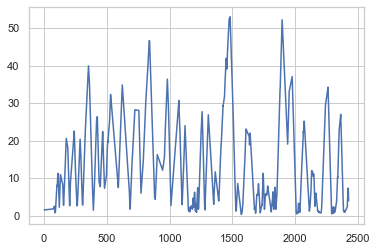

In [84]:
plt.plot(fdf_windy.mean_time,fdf_windy.avg_dist_from_source)

In [85]:
len(fdf_windy.mean_time)

2842

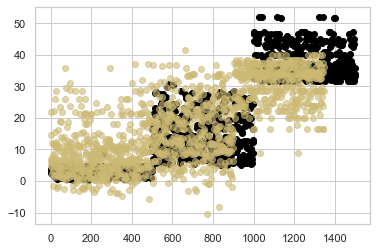

In [75]:
fig, ax = plt.subplots()
ax.plot(traindf.distance,'o',c='black',)
ax.plot(ypred,'o',c='y',alpha=0.6)


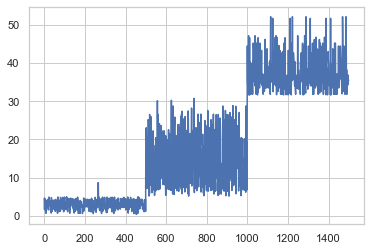

In [16]:
plt.plot(traindf.distance)

### all features

In [125]:
## TRAINED WITH NOT WINDY AND TESTED on WINDY
clf = GaussianNB()
# clf = GaussianProcessClassifier(kernel=1.0 * RBF(1.0),random_state=0)
# clf = make_pipeline(StandardScaler(), SVC(C=1,gamma=2))
# clf = RandomForestClassifier(random_state=1, n_estimators=100)

y_pred = clf.fit(Xtrain,ytrain).predict(Xtest)
print("Naive Bayes Test set Score: ",clf.score(Xtest, ytest))
print("Number of mislabeled points out of a total %d points : %d"
      % (Xtrain.shape[0], (ytest != y_pred).sum()))
print("Accuracy:",metrics.accuracy_score(ytest, y_pred))

Naive Bayes Test set Score:  0.8413333333333334
Number of mislabeled points out of a total 1500 points : 238
Accuracy: 0.8413333333333334


### for plotting 2d

In [126]:
#Train
# train = StandardScaler().fit_transform(Xtrain)
pca = PCA(n_components=6)
principalComponents1 = pca.fit_transform(Xtrain)
principalDf1=pd.DataFrame()
principalDf1 = pd.DataFrame(data = principalComponents1
             , columns = ['principal1', 'principal2', 'principal3','principal4',
                         'principal5','principal6'])
# X_train= np.vstack((principalDf1.principal1,principalDf1.principal2))
X_train = np.reshape(np.vstack((principalDf1.principal1,principalDf1.principal2,principalDf1.principal3,
                               principalDf1.principal4,
                                principalDf1.principal5,principalDf1.principal6)),(1500,6))

# X_train= np.vstack((principalDf1.principal1,principalDf1.principal2)).T
##Test
# test=StandardScaler().fit_transform(Xtest)
principalComponents2=pca.fit_transform(Xtest)
principalDf2=pd.DataFrame()
principalDf2 = pd.DataFrame(data = principalComponents2
             , columns = ['principal1', 'principal2','principal3','principal4',
                         'principal5','principal6'])
# X_test= np.vstack((principalDf2.principal1,principalDf2.principal2))
X_test = np.reshape(np.vstack((principalDf2.principal1,principalDf2.principal2,principalDf2.principal3,
                               principalDf2.principal4,
                               principalDf2.principal5,principalDf2.principal6)),(1500,6))

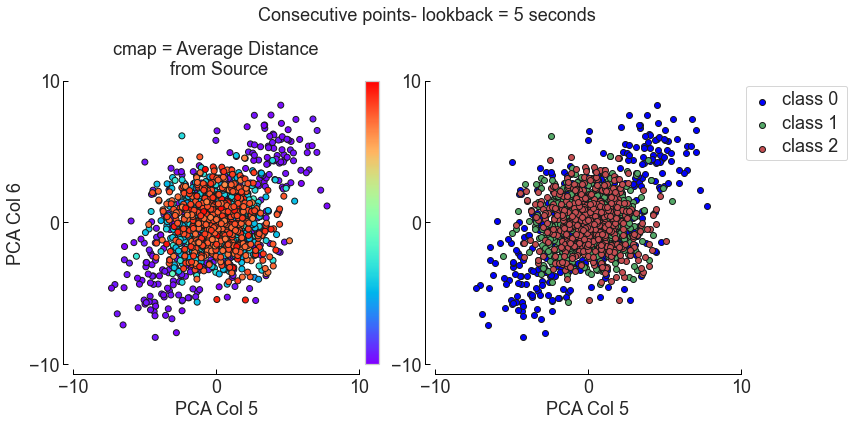

In [130]:
f,(ax1,ax2)=plt.subplots(1,2, figsize=(12,6))
ax1.grid(False)
ax2.grid(False)
col1=4
col2=5
var=ax1.scatter(X_train[:, col1], X_train[:, col2], c=D_train, cmap='rainbow', edgecolors="k")
ax1.set_xlabel('PCA Col 5')
ax1.set_ylabel('PCA Col 6')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var, cax=cax, orientation = 'vertical', ticks=[1, 51])
cbar.ax.set_yticklabels(['0', '51'])
cbar.solids.set(alpha=1)


ax2.scatter(X_train[:500, col1], X_train[:500, col2], c='blue', edgecolors="k",label='class 0 ')
ax2.scatter(X_train[500:1000, col1], X_train[500:1000, col2], c='g', edgecolors="k",label='class 1 ')
ax2.scatter(X_train[1000:1500, col1], X_train[1000:1500, col2], c='r', edgecolors="k",label='class 2 ')
ax2.set_xlabel('PCA Col 5')
# ax2.set_ylabel('PCA Col 2')
ax1.set_title('cmap = Average Distance\n from Source')
# ax2.set_title('cmap = Class')
ax2.legend(bbox_to_anchor=(1, 1))
mpl_functions.adjust_spines(ax1,['left','bottom'],spine_locations={}, 
                                smart_bounds=True,
                                xticks=[-10,0,10],
                                yticks=[-10,0,10],
                                linewidth=1)
mpl_functions.adjust_spines(ax2,['left','bottom'],spine_locations={}, 
                                smart_bounds=True,
                                xticks=[-10,0,10],
                                yticks=[-10,0,10],
                                linewidth=1)



f.suptitle('Consecutive points- lookback = 5 seconds')
figurefirst.mpl_functions.set_fontsize(f, 18)
f.tight_layout(pad=1)
# f.savefig('../../Figure/compare_pca_timed_col56.jpeg', dpi=300, bbox_inches = "tight"

In [184]:
# clf = GaussianNB()
# clf = GaussianProcessClassifier(kernel=1.0 * RBF(1.0),random_state=0)
clf = make_pipeline(StandardScaler(), SVC(C=1,gamma=2))
# clf = RandomForestClassifier(max_depth=5,random_state=1, n_estimators=100)



y_pred = clf.fit(X_train,ytrain).predict(X_test)
print("Test set Score: ",clf.score(X_test, ytest))
print("Number of mislabeled points out of a total %d points : %d"
      % (X_train.shape[0], (ytest != y_pred).sum()))
print("Accuracy:",metrics.accuracy_score(ytest, y_pred))

Test set Score:  0.7246666666666667
Number of mislabeled points out of a total 1500 points : 413
Accuracy: 0.7246666666666667


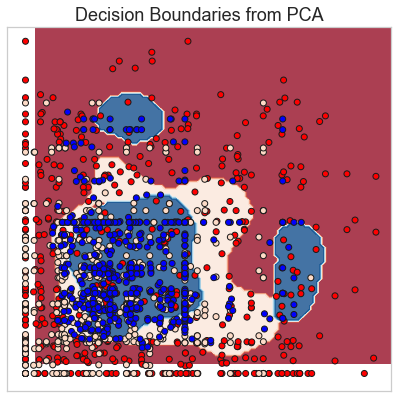

In [168]:
f,ax = plt.subplots(1,1,figsize=(6,6))
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#FDDBC7","#0000FF"])

ax.grid(False)
DecisionBoundaryDisplay.from_estimator(
            clf, X_train, cmap=cm, alpha=0.8, ax=ax, eps=0.5)

# Plot the training points
# ax.scatter(X_train[:, 0], X_train[:, 1], c=ytrain, cmap=cm_bright, edgecolors="k")

# Plot the test points
ax.scatter(X_test[:, 0], X_test[:, 1], c=ytest, cmap=cm_bright, edgecolors="k")
ax.set_title('Decision Boundaries from PCA')
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])

figurefirst.mpl_functions.set_fontsize(f, 18)
f.tight_layout(pad=2)
# f.savefig('../../Figure/boundary_pca_RF.jpeg', dpi=300, bbox_inches = "tight")

In [19]:
# clf = GaussianNB()
clf = make_pipeline(StandardScaler(), SVC(C=1,gamma=2))
# clf = RandomForestClassifier(random_state=1, n_estimators=100)

kernel = 1.0 * RBF(1.0)
# clf = GaussianProcessClassifier(kernel=kernel, random_state=0)
n=2
y_pred = clf.fit(Xtrain[:,:n],ytrain).predict(Xtest[:,:n])
print("Naive Bayes Test set Score: ",clf.score(Xtest[:,:n], ytest))

# # print("Naive Bayes Train set Score: ",clf.score(Xtrain, ytrain))
print("Number of mislabeled points out of a total %d points : %d"
      % (Xtrain[:,:n].shape[0], (ytest != y_pred).sum()))

print("Accuracy:",metrics.accuracy_score(ytest, y_pred))
# print(metrics.classification_report(ytest, y_pred))

Naive Bayes Test set Score:  0.5593333333333333
Number of mislabeled points out of a total 1500 points : 661
Accuracy: 0.5593333333333333


In [68]:
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#FDDBC7","#0000FF"])
f,ax = plt.subplots(1,1,figsize=(6, 6))
DecisionBoundaryDisplay.from_estimator(
            clf, Xtrain, cmap=cm, alpha=0.8, ax=ax, eps=0.5)
# Plot the training points
# ax.scatter(Xtrain[:, 0], Xtrain[:, 1], c=ytrain, cmap=cm_bright, edgecolors="k")
# Plot the testing points
# ax.scatter(Xtest[:, 0], Xtest[:, 1], c=ytest, cmap=cm_bright, edgecolors="k")

ax.set_title('Decision Boundaries - First two columns')
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])

figurefirst.mpl_functions.set_fontsize(f, 22)
f.tight_layout(pad=2)
# f.savefig('../../Figure/boundary_gp.jpeg', dpi=300, bbox_inches = "tight")

### Get Classwise accuracy


In [ ]:
accuracy = []

number_of_encounters = 15
trainset= fdf_notwindy
testset = fdf_windy

for i in range (0,5): #bootstrapping
    Xtest = []
    ytest = []
    Xtrain = []
    ytrain = []
    
    for distance_class in [0,1,2]:
        Xtrain,ytrain = gather_stat_random(trainset,distance_class,number_of_encounters, Xtrain,ytrain) 
    Xtrain = stack_arrays(Xtrain)


    for distance_class in [0,1,2]:
        Xtest,ytest = gather_stat_random(testset,distance_class,number_of_encounters, Xtest,ytest)    
    Xtest = stack_arrays(Xtest)
    
    clf = GaussianNB()
    y_pred = clf.fit(Xtrain,ytrain).predict(Xtest)
    
    accuracy.append(class_population_accuracy(ytest,y_pred))

accdf=pd.DataFrame()
accdf['class_0']=[item[0] for item in accuracy]
accdf['class_1']=[item[1] for item in accuracy]
accdf['class_2']=[item[2] for item in accuracy]

### Plotting Classwise Accuracy

In [5]:
# acc.drop(list(acc.filter(regex = 'feature')), axis = 1, inplace = True)
feature_number=np.arange(1,51,1)
confidence_interval_1=[]
confidence_interval_2=[]
confidence_interval_3=[]
median_1=[]
median_2=[]
median_3=[]
for i in range(0,len(acc.columns),3):
    confidence_interval_1.append(st.t.interval(alpha=0.95, 
                                              df=len(acc)-1, loc=np.mean(acc.iloc[:,i]), 
                                              scale=st.sem(acc.iloc[:,i]))) 
    median_1.append(np.median(acc.iloc[:,i]))

    confidence_interval_2.append(st.t.interval(alpha=0.95, 
                                              df=len(acc)-1, loc=np.mean(acc.iloc[:,i+1]), 
                                              scale=st.sem(acc.iloc[:,i+1]))) 
    median_2.append(np.median(acc.iloc[:,i+1]))
    confidence_interval_3.append(st.t.interval(alpha=0.95, 
                                              df=len(acc)-1, loc=np.mean(acc.iloc[:,i+2]), 
                                              scale=st.sem(acc.iloc[:,i+2], nan_policy='omit'))) 
    median_3.append(np.median(acc.iloc[:,i+2]))
    
## storing in a dataframe
df_interval = pd.DataFrame({'cl_1_int_1': np.array(confidence_interval_1)[:,0],
                        'cl_1_int_2': np.array(confidence_interval_1)[:,1],
                        'cl_2_int_1': np.array(confidence_interval_2)[:,0],
                        'cl_2_int_2': np.array(confidence_interval_2)[:,1],
                        'cl_3_int_1': np.array(confidence_interval_3)[:,0],
                        'cl_3_int_2': np.array(confidence_interval_3)[:,1],
                        'median_cl_1':median_1,
                        'median_cl_2':median_2,
                        'median_cl_3':median_3,
                        'feature':feature_number})

In [6]:
# df_interval.isnull().values.any()
## Interpolating NaNs
# df_interval.cl_3_int_1 = df_interval.cl_3_int_1.interpolate(method='nearest')
# df_interval.cl_3_int_2 = df_interval.cl_3_int_2.interpolate(method='nearest')

In [7]:
f,ax=plt.subplots(1,1,figsize=(8,6))
ax.grid(False)
ax.scatter(df_interval.feature, df_interval.median_cl_1, label='Median Class 1 - 0<D<7m')
ax.scatter(df_interval.feature, df_interval.median_cl_2, label='Median Class 2 - 11m<D<25m')
ax.scatter(df_interval.feature, df_interval.median_cl_3, label='Median Class 3 - D>30m')

ax.fill_between(df_interval.feature, df_interval['cl_1_int_1'], df_interval['cl_1_int_2'],
                where=df_interval['cl_1_int_2'] >= df_interval['cl_1_int_1'],
                facecolor='blue', alpha=0.2, interpolate=True)

ax.fill_between(df_interval.feature, df_interval['cl_2_int_1'], df_interval['cl_2_int_2'],
                where=df_interval['cl_2_int_2'] >= df_interval['cl_2_int_1'],
                facecolor='blue', alpha=0.2, interpolate=True)

ax.fill_between(df_interval.feature, df_interval['cl_3_int_1'], df_interval['cl_3_int_2'],
                where=df_interval['cl_3_int_2'] >= df_interval['cl_3_int_1'],
                facecolor='blue', alpha=0.2, interpolate=True)
ax.set_xlabel('N_Features')
ax.set_ylabel('% Class Accuracy')

mpl_functions.adjust_spines(ax,['left','bottom'],spine_locations={}, 
                                smart_bounds=True,
                                xticks=[0,10,20,30,40,50],
#                                 yticks=[0.5,0.8],
                                linewidth=1)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Desert tested on LWS')
figurefirst.mpl_functions.set_fontsize(f, 18)

f.tight_layout(pad=2)
# f.savefig('../../Figure/accuracy_desert_nwindy.jpeg', dpi=300, bbox_inches = "tight")

False